# OCR notebook
>This notebook uses Tensorflow/Keras to train an OCR model.

#1. Environment preparation

In [1]:
import os
import gc
import shutil
import urllib
import zipfile
from pathlib import Path
from datetime import datetime
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
print(f"Tensorflow {tf.__version__}")
print(f"Numpy {np.__version__}")

Tensorflow 2.4.1
Numpy 1.19.5


In [3]:
np.random.seed(42)

##A: Colab settings

>Run these cells to prepare the environment running on Google Colab (Linux).

In [27]:
sep = "/"
#Edit this to point to project root
home = f"{sep}content{sep}drive{sep}My Drive{sep}Machine Learning{sep}Stolen Vehicle Detector{sep}OCR{sep}"

local_home = f"{sep}content{sep}OCR{sep}"
if not os.path.exists(local_home):
    os.makedirs(local_home)

### Mount Google Drive to this Notebook instance
>As the dataset has been prepared previously and updated to Google Drive, the model building and training process will be done there, not locally.

In [28]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

os.chdir(local_home)
# Show current directory
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/OCR


##B: Windows settings

>Run these cells to prepare the environment running on a Windows local machine.

In [ ]:
#Edit this to point to project root
sep = "\\"
home = f"B:{sep}Dev{sep}GitHub{sep}University{sep}MSc Thesis{sep}StolenVehicleDetector{sep}Machine Learning{sep}OCR{sep}"
local_home = f"{home}"

## Define & create directories

>Paths defined to work both remotely and locally.

In [30]:
source_data_dir = f"{home}data{sep}"
local_data_dir = f"{local_home}data{sep}"

training_dir = f"{home}training{sep}"
checkpoint_dir = f"{training_dir}checkpoint{sep}"
log_dir = f"{training_dir}logs{sep}"

model_dir = f"{home}model{sep}"
model_tmp_dir = f"{model_dir}tmp{sep}"
keras_dir = f"{model_dir}keras{sep}"
tflite_dir = f"{model_dir}tflite{sep}"

In [7]:
#Setup project directories
if not os.path.exists(home):
    os.makedirs(home)
if not os.path.exists(local_home):
    os.makedirs(local_home)

if not os.path.exists(source_data_dir):
    os.makedirs(source_data_dir)
if not os.path.exists(local_data_dir):
    os.makedirs(local_data_dir)

if not os.path.exists(training_dir):
    os.makedirs(training_dir)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

if not os.path.exists(model_dir):
    os.makedirs(model_dir)
if not os.path.exists(model_tmp_dir):
    os.makedirs(model_tmp_dir)
if not os.path.exists(keras_dir):
    os.makedirs(keras_dir)
if not os.path.exists(tflite_dir):
    os.makedirs(tflite_dir)

#2. Dataset preparation

In [8]:
class AbstractDatasetLoader:
    '''Abstract dataset loader class
    '''
    dataset_name = ""
    source_url: str = ""

    def __init__(self, data_dir: str) -> None:
        self.data_dir = data_dir
        self.dataset_dir = self.data_dir + self.dataset_name
        self.image_IDs = []
        self.labels = []
        self.characters: set = set()
        self.label_max_length: int = 0

    def __download_dataset(self):
        pass

    def __extract_dataset(self):
        pass

    def prepare(self):
        '''Prepare the whole dataset before working with it
        '''
        pass

    def show_info(self):
        '''Show dataset properties
        '''
        print("Number of images: ", len(self.image_IDs))
        print("Number of labels: ", len(self.labels))
        print("Longest label: ", self.label_max_length)
        print("Number of unique characters: ", len(self.characters))
        print("Characters present: ", self.characters)


class CaptchaDatasetLoader(AbstractDatasetLoader):
    '''The captcha dataset loader class
    '''

    dataset_name = "captcha_images_v2"
    source_url: str = "https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip"

    def __init__(self, data_dir: str) -> None:
        super().__init__(data_dir)
        self.download_file_name = self.dataset_dir + ".zip"

    def __download_dataset(self):
        download_file_path = Path(self.download_file_name)
        if not download_file_path.exists():
            #Not yet downloaded
            urllib.request.urlretrieve(self.source_url, download_file_path)

    def __extract_dataset(self):
        download_file_path = Path(self.download_file_name)
        if download_file_path.exists():
            #if the target data directory is empty, extract the zip file
            with zipfile.ZipFile(self.download_file_name, 'r') as zip_ref:
                zip_ref.extractall(path = self.data_dir)

    def load(self):
        '''Loads the whole dataset before working with it
        '''
        # Download & extract dataset if it has not been yet
        self.__download_dataset()
        self.__extract_dataset()

        dataset_path = Path(self.dataset_dir)
        # Get list of the images
        self.image_IDs = sorted(list(map(str, list(dataset_path.glob("*.png")))))
        # Labels of images: image names minus ".png"
        self.labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in self.image_IDs]
        # Set of distinct characters in the labels
        characters = set(char for label in self.labels for char in label)
        self.characters = sorted(characters)
        # Compute the longest label in the dataset
        self.label_max_length = max([len(label) for label in self.labels])

    def split_data(self, train_ratio, shuffle=True):
        # Get the total size of the dataset
        size = len(self.image_IDs)
        # Make an indices array and shuffle it, if required
        indices = np.arange(size)
        if shuffle:
            np.random.shuffle(indices)
        # Get the size of the training samples
        train_samples = int(size * train_ratio)

        images = np.array(self.image_IDs)
        labels = np.array(self.labels)

        # Split data into training and validation sets
        x_train, y_train = images[indices[:train_samples]], images[indices[train_samples:]]
        x_valid, y_valid = labels[indices[:train_samples]], labels[indices[train_samples:]]

        return x_train, x_valid, y_train, y_valid

In [9]:
data_loader = CaptchaDatasetLoader(local_data_dir)
data_loader.load()
data_loader.show_info()

Number of images:  1040
Number of labels:  1040
Longest label:  5
Number of unique characters:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [10]:
#Training set ratio
train_ratio = 0.9
shuffle = True

In [11]:
# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = data_loader.split_data(train_ratio, shuffle)

In [12]:
class DatasetWrapper():

    def __init__(self, characters, image_IDs, labels, image_dim=(200,200), n_channels=3, batch_size=16, shuffle=True, max_block_length=25, oov_token='[?]'):
        self.image_IDs = image_IDs
        # Uniformly transform labels to [0:max_block_length] sized
        self.labels = [label.ljust(max_block_length)[0:max_block_length] for label in labels]
        self.image_dim = image_dim
        self.n_channels = n_channels
        self.shuffle = shuffle

        self.max_block_length = max_block_length
        self.oov_token = oov_token

        self.batch_size = batch_size
        self.num_items = len(self.image_IDs)
        self.num_batches = int(np.floor(self.num_items / self.batch_size))

        # Mapping characters to integers
        self.char_to_num = layers.experimental.preprocessing.StringLookup(
            vocabulary=list(characters), num_oov_indices=1, oov_token=self.oov_token, mask_token=None, invert=False
        )

        # Mapping integers back to characters
        self.num_to_char = layers.experimental.preprocessing.StringLookup(
            vocabulary=self.char_to_num.get_vocabulary(), num_oov_indices=1, oov_token=self.oov_token, mask_token=None, invert=True
        )

        self.dataset = tf.data.Dataset.from_tensor_slices((self.image_IDs, self.labels))
        self.dataset = self.dataset.shuffle(self.num_items, reshuffle_each_iteration=self.shuffle)
        self.dataset = (
            self.dataset.map(
            self.get_item, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            .batch(self.batch_size)
            .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        )

    def data_to_dict(self, image, label):
        # Return a dict
        return {"image": image, "label": label}

    def encode_data(self, img_path, char_label):
        # Read the image
        img = tf.io.read_file(img_path)
        # Decode and convert to have the required amount of channels
        img = tf.io.decode_image(img, channels=self.n_channels)
        # Convert to float32 in [0, 1) range
        img = tf.image.convert_image_dtype(img, tf.float32)
        # Resize to the desired size
        img = tf.image.resize_with_pad(img, self.image_dim[0], self.image_dim[1])
        # keep the characters in the range of [0:self.max_block_length]
        char_label = tf.strings.substr(char_label, 0, self.max_block_length, unit='BYTE', name=None)
        # Splits each string in input into a sequence of Unicode code point
        char_label = tf.strings.unicode_split(char_label, input_encoding="UTF-8")
        # Map the characters in a block to numbers
        num_label = self.char_to_num(char_label)
        # Return the encoded results
        return img, num_label
        
    def get_item(self, img_path, char_label):
        image, label = self.encode_data(img_path, char_label)
        return self.data_to_dict(image, label)

    def decode_image(self, encoded_image):
        # Only one image
        # dimension to correspond to the original order
        #decoded_image = tf.transpose(encoded_image, perm=[1, 0, 2])
        decoded_image = (encoded_image * 255).numpy().astype("uint8")
        return decoded_image

    def decode_label(self, encoded_label, replace_oov):
        # Only one text block
        decoded_label = self.num_to_char(encoded_label)
        decoded_label = tf.strings.reduce_join(decoded_label).numpy().decode("utf-8")
        if replace_oov:
            decoded_label = decoded_label.replace(self.oov_token, '')
        return decoded_label

#3. Training configuration

In [13]:
#Required input image dimensions (N x N images)
img_h = 50 #200
img_w = 200
#3 means RGB, 1 means grayscale
n_channels = 1

In [14]:
loaded_characters = set(line.strip() for line in open(f"{source_data_dir}{sep}characters.txt"))
loaded_characters = sorted(loaded_characters)
print(loaded_characters)
print(len(loaded_characters))

['!', '"', '#', '$', '%', '&', '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~']
66


In [15]:
# Batch size for training and validation
batch_size = 16
characters = loaded_characters
# Number of characters to process
num_characters = len(characters)
max_block_length = 20

In [16]:
train = DatasetWrapper(characters, x_train, x_valid, image_dim=(img_h, img_w), n_channels=n_channels, 
    batch_size=batch_size, shuffle=True, max_block_length=max_block_length)
    
validation = DatasetWrapper(characters, y_train, y_valid, image_dim=(img_h, img_w), n_channels=n_channels, 
    batch_size=batch_size, shuffle=False, max_block_length=max_block_length)

##Test label encoding/decoding

In [17]:
char_to_encode = b'y'

num = train.char_to_num(char_to_encode)
print(num)

char = train.num_to_char(num)
print(char)

tf.Tensor(61, shape=(), dtype=int64)
tf.Tensor(b'y', shape=(), dtype=string)


In [18]:
label = "can you 23456 love tonight??"
print(label)

image, encoded_label = train.encode_data(local_data_dir + f"captcha_images_v2{sep}226md.png", label)
print(encoded_label)

decoded_label = train.decode_label(encoded_label, False)
print(decoded_label)
decoded_label_no_oov = train.decode_label(encoded_label, True)
print(decoded_label_no_oov)

can you 23456 love tonight??
tf.Tensor([39 37 50  0 61 51 57  0 17 18 19 20 21  0 48 51 58 41  0 56], shape=(20,), dtype=int64)
can[?]you[?]23456[?]love[?]t
canyou23456lovet


##Inspect dataset

In [19]:
for batch in train.dataset.take(1):
    labels = batch['label']
    print(labels)

    label_lengths_list = tf.TensorArray(tf.int64, size=len(labels))

    for i in range(len(labels)):
        length = [tf.math.count_nonzero(labels[i])]
        label_lengths_list = label_lengths_list.write(i, length)

    label_lengths = label_lengths_list.stack()
    print(label_lengths)


tf.Tensor(
[[49 59 60 59 52  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [22 40 43 39 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [50 19 21 19 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [42 61 59 38 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [40 17 17 61 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [22 42 49 39 61  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [42 21 50 41 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [49 43 40 59 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [39 39 50 17 60  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [50 42 38 43 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [43 50 38 40 41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [19 42 23 61 52  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [40 50 17 61 49  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [17 41 50 42 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [17 18 20 21 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [59 39 41 20 50  0  0  0  0  0  0  0  0  0 

In [20]:
def show_dataset_sample(dataset_wrapper):
    batch_size = dataset_wrapper.batch_size
    img_in_line = 4
    num_lines = dataset_wrapper.batch_size//img_in_line
    img_size_w = 4
    img_size_h = 2
    _, ax = plt.subplots(num_lines, img_in_line, figsize=(img_in_line*img_size_w, num_lines*img_size_h))

    for batch in dataset_wrapper.dataset.take(1):
        images = batch['image']
        labels = batch['label']

        for i in range(batch_size):
            img = dataset_wrapper.decode_image(images[i])
            # if image has only one channel, drop channel dim to plot with matplotlib
            if(img.shape[2] == 1):
                img = img[:,:,0]

            label = dataset_wrapper.decode_label(labels[i], True)
            ax[i // img_in_line, i % img_in_line].imshow(img)
            ax[i // img_in_line, i % img_in_line].set_title(label)

    plt.show()

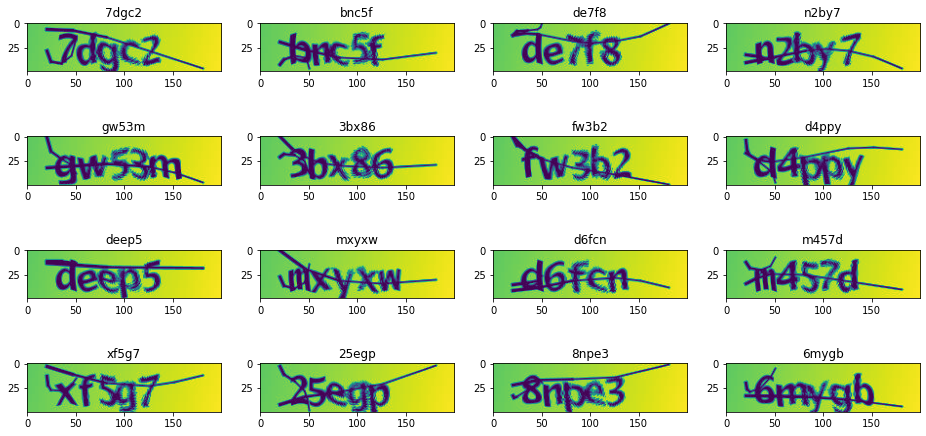

In [21]:
show_dataset_sample(train)

#4. Model creation

##CTC layer

In [22]:
class CTCLayer(layers.Layer):
    
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        '''
        y_true: tf.tensor with shape (batch_size, max_len), dtype=int64
        y_pred: tf.tensor with shape (batch_size, max_timesteps, num_characters), dtype=float
        '''

        # Compute the training time loss
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int32")
        label_lengths = tf.TensorArray(tf.int64, size=tf.shape(y_true)[0])

        def loop_body(i, label_lengths):
            return i + 1, label_lengths.write(i, [tf.math.count_nonzero(y_true[i])])

        _, label_lengths = tf.while_loop(lambda i, label_lengths: i < batch_len, loop_body, [0, label_lengths])
        label_lengths = label_lengths.stack()

        pred_lengths = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        pred_lengths = pred_lengths * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, pred_lengths, label_lengths)
        # Add it to the parent layer
        self.add_loss(loss) 

        # At inference, just return the model predictions
        return y_pred

###CTC layer test call

In [23]:
# shape: batch_size x max_len
true = tf.constant(([[1,8,6,3], [1,9,0,0]]), dtype="int64")
# shape: batch_size x max_timesteps x num_characters
pred = tf.zeros(shape=(2, 25, 10), dtype="float")

#ctc = CTCLayer()
#ctc.call(true, pred)

###Compare Python loop with tf.while_loop

> The custom CTC layer uses a `tf.while_loop`. As inference speed is critical there, benchmark testing has been implemented. In general, the Python loop is 1.3x faster than the tensorflow loop, which is the only possibility to iterate through dynamic tensors. This is essential to calculate input label lengths on the fly, and pass to `keras.backend.ctc_batch_cost`.

In [ ]:
def tf_loop():
    true = tf.constant(([[1,8,6,3], [1,9,0,0]]), dtype="int64")
    batch_len = tf.cast(tf.shape(true)[0], dtype="int32")
    label_lengths = tf.TensorArray(tf.int64, size=tf.shape(true)[0])

    def loop_body(i, label_lengths):
        label_lengths.write(i, [tf.math.count_nonzero(true[i])]).mark_used()
        return i + 1, label_lengths

    _, label_lengths = tf.while_loop(
        lambda i, label_lengths: i < batch_len, loop_body, [0, label_lengths])

    label_lengths = label_lengths.stack()
    #print(label_lengths)
    return label_lengths

def python_loop():
    true = tf.constant(([[1,8,6,3], [1,9,0,0]]), dtype="int64")
    batch_len = tf.cast(tf.shape(true)[0], dtype="int32")
    label_lengths = tf.TensorArray(tf.int64, size=tf.shape(true)[0])

    for i in range(batch_len):
        label_length = [tf.math.count_nonzero(true[i])]
        label_lengths.write(i, label_length).mark_used()

    label_lengths = label_lengths.stack()
    #print(label_lengths)
    return label_lengths

In [ ]:
import timeit
num_iters = 10000

tf_avg = (timeit.timeit(tf_loop, number=num_iters)/num_iters)*1000
python_avg = (timeit.timeit(python_loop, number=num_iters)/num_iters)*1000

print(f"TF loop: {tf_avg} ms")
print(f"Python loop: {python_avg} ms")

TF loop: 1.6681964359000006 ms
Python loop: 1.3388843366999994 ms


##Model definition

In [24]:
def ocr_model_v1(image_dim: (int, int), channels: int, num_characters: int, optimizer):
    #Factor by which the image is going to be downsampled by the convolutional blocks.
    #Two convolutional blocks are used; each block has a pooling layer which downsample the features by a factor of 2.
    #Thus, the total downsampling factor is (2x2)=4.
    downsample_factor = 4
    #Model inputs
    input_image = layers.Input(shape=(image_dim[0], image_dim[1], channels), name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # Make the first dimension correspond to the width of the image
    # RNN part "reads" the image from left to right (instead of top to bottom)
    x = layers.Permute((2, 1, 3), name="Permute")(input_image)

    #1st conv block
    x = layers.Conv2D(32, (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(x)
    #1st max pooling
    x = layers.MaxPooling2D((2, 2), name="Pool1")(x)

    #2nd conv block
    x = layers.Conv2D(64, (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    #2nd max pooling
    x = layers.MaxPooling2D((2, 2), name="MaxPool2")(x)

    # Two max pool have been used with pool size and strides 2.
    # This way, the downsampled feature maps are 4x smaller. 
    # The number of filters in the last layer is 64. 
    # Reshape accordingly before passing the features to the RNN part.
    # image_dim[1], image_dim[0] has reversed order because layers.Permute changed dim 1 & dim 2
    new_shape = ((image_dim[1] // downsample_factor), (image_dim[0] // downsample_factor) * 64)
    x = layers.Reshape(target_shape=new_shape, name="Reshape")(x)
    x = layers.Dense(64, activation="relu", name="Dense1")(x)
    x = layers.Dropout(0.2, name="Dropout")(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25), name="LSTM1")(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25), name="LSTM2")(x)

    # Output layer
    # +1 for empty character, +1 for zero padding
    x = layers.Dense(num_characters+2, activation="softmax", name="Dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="CTCloss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_image, labels], outputs=output, name="ocr_model_v1")
    # Optimizer
    optimizer = optimizer
    # Compile the model
    model.compile(optimizer=optimizer)
    #Return the model to use
    return model

##Build model

In [25]:
# Create the model
optimizer = keras.optimizers.Adam()
model = None
gc.collect()
model = ocr_model_v1((img_h, img_w), n_channels, num_characters, optimizer)
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 50, 200, 1)] 0                                            
__________________________________________________________________________________________________
Permute (Permute)               (None, 200, 50, 1)   0           image[0][0]                      
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         Permute[0][0]                    
__________________________________________________________________________________________________
Pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
_______________________________________________________________________________________

#5. Training configuration

##General parameters, general callbacks

In [ ]:
epochs = 200 #1000

# Early stopping configuration
early_stopping_patience = 20 #50
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, verbose=1, restore_best_weights=True
)

# Save model checkpoint configuration
save_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    monitor="val_loss", mode='auto', filepath=checkpoint_dir, save_weights_only=True, save_best_only=True
)

# Remove previous log folder
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
# Recreate log folder
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
# TensorBoard configuration
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

##Specific callbacks

In [ ]:
# Learning rate scheduler
n_epochs_before_lr_decrease = 100
# Keep the initial learning rate for the first n_epochs_before_lr_decrease and decrease exponentially after that
def lr_schedule(epoch, lr):
    if epoch < n_epochs_before_lr_decrease:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# Reduce learning rate on plateau configuration
on_plateau_patience = 10
on_plateau_min_delta = 0.0001
on_plateau_min_lr = 1e-5
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=on_plateau_patience, verbose=1, mode='auto', 
    min_delta=on_plateau_min_delta, cooldown=0, min_lr=on_plateau_min_lr
)

##TensorBoard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
print(log_dir)

/content/drive/My Drive/Machine Learning/Stolen Vehicle Detection/OCR/training/logs/


In [ ]:
%tensorboard --logdir "/content/drive/My Drive/Machine Learning/Stolen Vehicle Detection/OCR/training/logs/"

#6. Training

In [ ]:
#Train the model
training_history = model.fit(
    train.dataset,
    validation_data=validation.dataset,
    epochs=epochs,
    callbacks=[early_stopping, save_checkpoint, tensorboard_callback]
)

Epoch 1/200
59/59 [==============================] - 42s 88ms/step - loss: 58.6303 - val_loss: 16.7486
Epoch 2/200
59/59 [==============================] - 2s 37ms/step - loss: 16.7076 - val_loss: 16.4890
Epoch 3/200
59/59 [==============================] - 2s 37ms/step - loss: 16.4570 - val_loss: 16.4746
Epoch 4/200
59/59 [==============================] - 2s 36ms/step - loss: 16.4530 - val_loss: 16.3948
Epoch 5/200
59/59 [==============================] - 2s 36ms/step - loss: 16.4337 - val_loss: 16.4170
Epoch 6/200
59/59 [==============================] - 2s 36ms/step - loss: 16.4041 - val_loss: 16.4093
Epoch 7/200
59/59 [==============================] - 2s 36ms/step - loss: 16.3731 - val_loss: 16.3809
Epoch 8/200
59/59 [==============================] - 2s 37ms/step - loss: 16.3715 - val_loss: 16.4075
Epoch 9/200
59/59 [==============================] - 2s 36ms/step - loss: 16.3569 - val_loss: 16.4150
Epoch 10/200
59/59 [==============================] - 2s 36ms/step - loss: 16.367

In [ ]:
best_loss = min(training_history.history["val_loss"])
n_epoch_trained = 75

#7. Evaluation

In [26]:
loss = model.evaluate(validation.dataset, verbose=2)
print("loss: {:2.4f}".format(loss))

7/7 - 31s - loss: 182.4798
loss: 182.4798


#8. Model I/O

##Save model

In [ ]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = f"{model.name}_{current_time}_captcha_epoch{n_epoch_trained}_loss{'{0:.4f}'.format(best_loss)}"
model.save(f"{keras_dir}{model_name}")
print(f"Model saved: {model_name}")

INFO:tensorflow:Assets written to: /content/drive/My Drive/Machine Learning/Stolen Vehicle Detection/OCR/model/keras/ocr_model_v1_20210313-221222_captcha_epoch75_loss0.0480/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Machine Learning/Stolen Vehicle Detection/OCR/model/keras/ocr_model_v1_20210313-221222_captcha_epoch75_loss0.0480/assets


Model saved: ocr_model_v1_20210313-221222_captcha_epoch75_loss0.0480


##Load model

In [31]:
model_name = f"ocr_model_v1_20210313-221222_captcha_epoch75_loss0.0480"
model = keras.models.load_model(f"{keras_dir}{model_name}")

# Re-evaluate the model
loss = model.evaluate(validation.dataset, verbose=2)
print("Loaded model, loss: {:2.4f}".format(loss))

7/7 - 2s - loss: 0.0480
Loaded model, loss: 0.0480


##Load weights

In [ ]:
# Loads the weights
model.load_weights(checkpoint_dir)

# Re-evaluate the model
loss = model.evaluate(validation.dataset, verbose=2)
print("Loaded model, loss: {:2.4f}".format(loss))

7/7 - 31s - loss: 0.0480
Loaded model, loss: 0.0480


#9. Inference model

>Create the pure prediction model & run inference on it.

##Build prediction model

In [32]:
prediction_model = None
gc.collect()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="Dense2").output)
prediction_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 50, 200, 1)]      0         
_________________________________________________________________
Permute (Permute)            (None, 200, 50, 1)        0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 200, 50, 32)       320       
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 100, 25, 32)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 100, 25, 64)       18496     
_________________________________________________________________
MaxPool2 (MaxPooling2D)      (None, 50, 12, 64)        0         
_________________________________________________________________
Reshape (Reshape)            (None, 50, 768)           0     

##Run inference

In [33]:
# A utility function to decode the output of the network
def batch_ctc_decode(preds, max_length):
    input_len = np.ones(preds.shape[0]) * preds.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(preds, input_length=input_len, greedy=True)[0][0][:, :max_length]
    return results

def show_inference_results(dataset_wrapper, model):

    batch_size = dataset_wrapper.batch_size
    img_in_line = 4
    num_lines = dataset_wrapper.batch_size//img_in_line
    img_size_w = 4
    img_size_h = 2

    _, ax = plt.subplots(num_lines, img_in_line, figsize=(img_in_line*img_size_w, num_lines*img_size_h))
    
    for batch in dataset_wrapper.dataset.take(1):
        images = batch['image']
        labels = batch['label']
        preds = model.predict(images)
        preds = batch_ctc_decode(preds, dataset_wrapper.max_block_length)

        for i in range(batch_size):
            img = dataset_wrapper.decode_image(images[i])
            # if image has only one channel, drop channel dim to plot with matplotlib
            if(img.shape[2] == 1):
                img = img[:,:,0]

            label = "Truth: " + dataset_wrapper.decode_label(labels[i], True) + "\nPred: " + dataset_wrapper.decode_label(preds[i], True)
            ax[i // img_in_line, i % img_in_line].imshow(img)
            ax[i // img_in_line, i % img_in_line].set_title(label)
    plt.show()

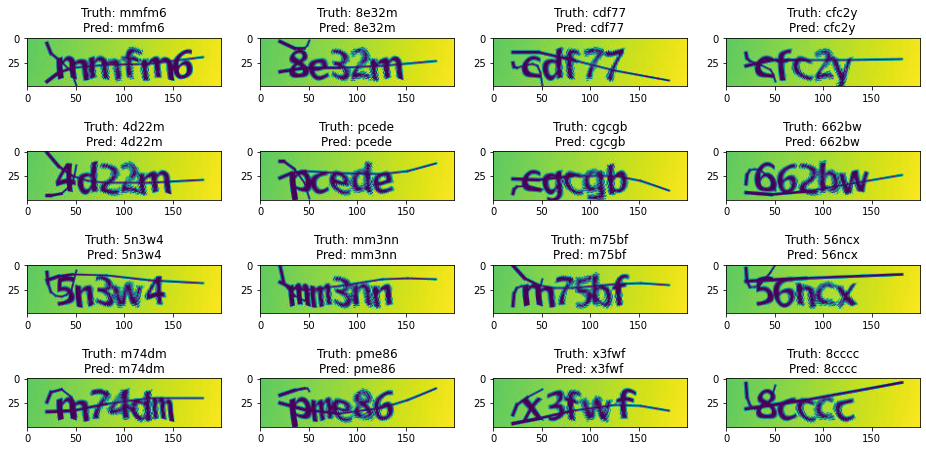

In [34]:
show_inference_results(validation, prediction_model)

#10. TFLite conversion

##Define source model, create individual tmp model

In [49]:
model_name = f"ocr_model_v1_20210313-221222_captcha_epoch75_loss0.0480"

#Save the pure prediction model to model_tmp_dir before the tflite conversion
source_model = keras.models.load_model(f"{keras_dir}{model_name}")
target_model = keras.models.Model(source_model.get_layer(name="image").input, source_model.get_layer(name="Dense2").output)
print(target_model.get_layer(name="image").input)
print(target_model.get_layer(name="Dense2").output)

target_model.input.set_shape((1, 50, 200, 1))
target_model.output.set_shape((1, 50, 68))
print(target_model.get_layer(name="image").input)
print(target_model.get_layer(name="Dense2").output)

target_model.save(model_tmp_dir)
source_model = None
target_model = None
gc.collect()

KerasTensor(type_spec=TensorSpec(shape=(None, 50, 200, 1), dtype=tf.float32, name='image'), name='image', description="created by layer 'image'")
KerasTensor(type_spec=TensorSpec(shape=(None, 50, 68), dtype=tf.float32, name=None), name='Dense2/truediv:0', description="created by layer 'Dense2'")
KerasTensor(type_spec=TensorSpec(shape=(1, 50, 200, 1), dtype=tf.float32, name='image'), name='image', description="created by layer 'image'")
KerasTensor(type_spec=TensorSpec(shape=(1, 50, 68), dtype=tf.float32, name=None), name='Dense2/truediv:0', description="created by layer 'Dense2'")


INFO:tensorflow:Assets written to: /content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/model/tmp/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/model/tmp/assets


719492

##Convert to tflite

>Note: Recurrent/LSTM layers have quantization issues due to a Tensorflow bug so full-integer quantization cannot be done at the moment (reason of uncommented lines). Dynamic range quantization is used, which reduces the size of the model to 1/4.

In [50]:
def representative_dataset():
     for item in train.dataset.take(100):
         yield item["image"]

In [51]:
converter = tf.lite.TFLiteConverter.from_saved_model(model_tmp_dir)
converter.experimental_new_converter = True
converter.experimental_new_quantizer = True

#Dynamic integer quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

#Full integer quantization
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#converter.inference_input_type = tf.int8  
#converter.inference_output_type = tf.int8 
#converter.representative_dataset = representative_dataset

tflite_model = converter.convert()
target_file_path = f"{tflite_dir}{model_name}.tflite"

# Save the tflite model
with open(target_file_path, 'wb') as f:
  f.write(tflite_model)
  print(f"Model saved successfully to {target_file_path}")

Model saved successfully to /content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/model/tflite/ocr_model_v1_20210313-221222_captcha_epoch75_loss0.0480.tflite


##TFLite model details

In [52]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_content=tflite_model)
#interpreter = tf.lite.Interpreter(model_path=f"{tflite_dir}model.tflite")

# Get input and output tensors
input = interpreter.get_input_details()
input_type = interpreter.get_input_details()[0]['dtype']
input_shape = input[0]['shape']
input_idx = input[0]['index']

output = interpreter.get_output_details()
output_type = interpreter.get_output_details()[0]['dtype']
output_shape = output[0]['shape']
output_idx = output[0]['index']

print('input: ', input)
print('type: ', input_type)
print('shape: ', input_shape)
print('index: ', input_idx)
print()
print('output: ', output)
print('type: ', output_type)
print('shape: ', output_shape)
print('index: ', output_idx)

input:  [{'name': 'serving_default_image:0', 'index': 0, 'shape': array([  1,  50, 200,   1], dtype=int32), 'shape_signature': array([  1,  50, 200,   1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
type:  <class 'numpy.float32'>
shape:  [  1  50 200   1]
index:  0

output:  [{'name': 'StatefulPartitionedCall:0', 'index': 97, 'shape': array([ 1, 50, 68], dtype=int32), 'shape_signature': array([ 1, 50, 68], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
type:  <class 'numpy.float32'>
shape:  [ 1 50 68]
index:  97


##TFLite model inference

In [58]:
# Generate random input image to test the model
random_input = np.array(np.random.random_sample(input_shape), dtype=np.float32)
print(random_input.shape)

(1, 50, 200, 1)


In [56]:
interpreter.allocate_tensors()

# Test the model on random input data
interpreter.set_tensor(input_idx, random_input)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data
# Use `tensor()` in order to get a pointer to the tensor
output_data = interpreter.get_tensor(output_idx)
print(output_data)
print(output_data.shape)

[[[1.78571000e-07 1.34133472e-07 4.41383037e-08 ... 1.16115736e-07
   6.50300649e-08 9.98995364e-01]
  [1.34827999e-07 1.05287533e-07 4.56630609e-08 ... 8.58329301e-08
   5.31830757e-08 9.98345256e-01]
  [7.60066200e-07 7.24380300e-07 4.37208342e-07 ... 7.34701473e-07
   4.32659419e-07 9.79511023e-01]
  ...
  [5.62360860e-08 3.83208700e-08 2.39778881e-08 ... 2.20866418e-08
   2.15142286e-08 9.99280512e-01]
  [4.15103341e-06 2.83586019e-06 1.76681726e-06 ... 1.97587519e-06
   2.46141917e-06 9.78881478e-01]
  [1.75214707e-04 1.48597595e-04 1.07506625e-04 ... 1.42020712e-04
   2.00134295e-04 7.24332631e-01]]]
(1, 50, 68)


In [59]:
np_output_data = np.array(output_data)
output = []

for item in np_output_data[0,:,]:
    output.append(np.argmax(item))

print(output)

[67, 67, 67, 67, 19, 67, 67, 67, 43, 43, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 43, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 43, 43, 67, 67, 67, 43, 43, 67, 67, 67, 67, 43, 67, 67, 67, 67]
